# 2.01 Figure 1

---

Author : Riley X. Brady

Date : 11/18/2020

Figure 1 showcases the trajectory and associated tracer time series for a single example particle.

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
import figutils
import numpy as np
import xarray as xr
import proplot as plot
import matplotlib.pyplot as plt

from dask.distributed import Client

In [2]:
import matplotlib

print(f"numpy: {np.__version__}")
print(f"xarray: {xr.__version__}")
print(f"proplot: {plot.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

numpy: 1.19.4
xarray: 0.16.1
proplot: 0.6.4
matplotlib: 3.3.3


In [3]:
# This is my TCP client from the `launch_cluster` notebook. I use it
# for distributed computing with `dask` on NCAR's machine, Casper.
client = Client("tcp://...")

## Analysis

In another exploratory notebook, I selected this particle ID as an interesting example for the paper.

In [4]:
particleid = 235455

# Load in the `zarr` file, which is pre-chunked and already has been
# filtered from the original 1,000,000 particles to the 19,002 that
# upwell last across 1000 m S of 45S and outside of the annual sea ice
# edge.
filepath = "../data/southern_ocean_deep_upwelling_particles.zarr/"
ds = xr.open_zarr(filepath, consolidated=True)
ds = ds.sel(nParticles=particleid)

The data folder also includes a netCDF file with helpful time info for the particles. This includes simulation days since initialization, date strings for the true model time of the particle (e.g. 0034-01-01), and some numpy datetime-formatted times in case any time-based operations need to be done.

In [5]:
# Put particles in proper time coordinates.
xtime = xr.open_dataset("../data/particle_time_info.nc")
ds["time"] = xtime.days_since_release / 365

In [6]:
# Can now load into memory, since it's quite small.
ds = ds.load()

In [7]:
# Bottom depth from the full Eulerian mesh.
depth = xr.open_dataset("../data/bottomDepth.nc").chunk()

# Subset to the relevant latitude range for easier computing.
conditions = (depth.latCell >= ds.latParticle.min()) & (
    depth.latCell <= ds.latParticle.max()
)
depth = depth.where(conditions, drop=True)

In [8]:
# Re-chunk since I'll be crawling through the unstructured mesh.
ds = ds.chunk({"time": 50})
depth = depth.chunk({"nCells": -1})

We now find a list of indices on the unstructured mesh that represent the closest Eulerian cell centers to the location of the Lagrangian particle at the given time step. With this, we can append the approximate bottom depth to the particle at each time step.

In [9]:
result = np.abs(depth.latCell - ds.latParticle) + np.abs(depth.lonCell - ds.lonParticle)
%time mesh_idx = result.argmin('nCells').compute()

# And now we can select those bottom depths to plot alongside the particle trajectory.
bd = depth.bottomDepth.load()
bathy = bd[mesh_idx]

CPU times: user 223 ms, sys: 7.39 ms, total: 231 ms
Wall time: 2.34 s


In [10]:
ds = ds.load()

# A script from my utilities file that derives a host of diagnostic
# variables from the particle trajectory, including potential pCO2.
ds = figutils.derive_variables(ds)

I use code from my utility script to find the *last* time the particle crossed 1000 m and the first time following that when it crossed 200 m.

In [11]:
deep_crossing = figutils.compute_idx_of_last_1000m_crossing(ds.zLevelParticle.values)
shallow_crossing = figutils.compute_idx_of_first_200m_crossing(ds.zLevelParticle.values)

## Visualization

### Panel A: Particle Tracer Time Series

/glade/work/rbrady/publications/2021_GRL_Lagrangian_Carbon_Pathways/notebooks/figutils.py:31: RuntimeWarning: invalid value encountered in true_divide
  return sum_product / ((len(x) - lag) * np.std(y1) * np.std(y2))
/glade/work/rbrady/publications/2021_GRL_Lagrangian_Carbon_Pathways/notebooks/figutils.py:31: RuntimeWarning: invalid value encountered in true_divide
  return sum_product / ((len(x) - lag) * np.std(y1) * np.std(y2))


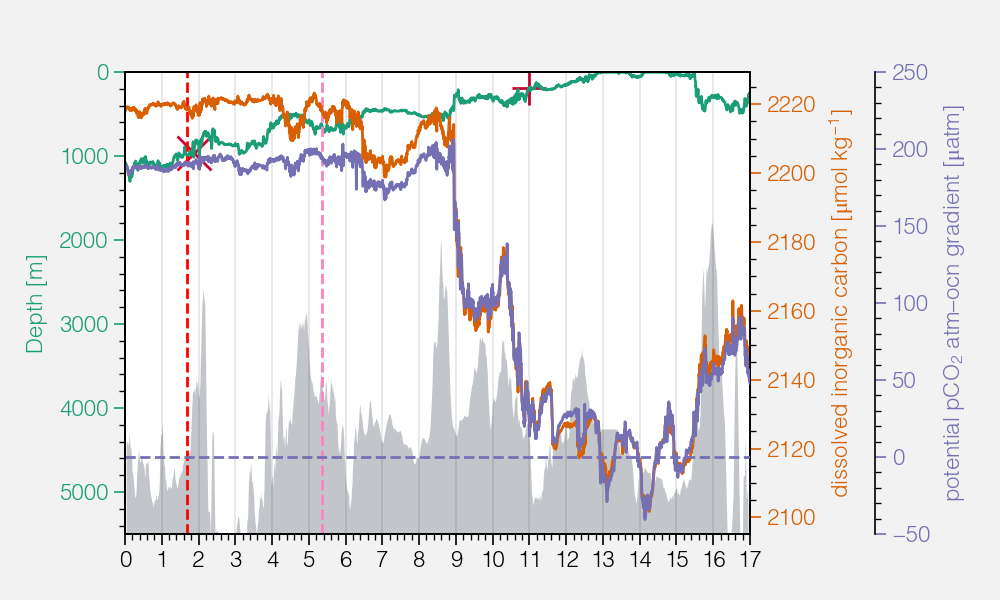

In [12]:
plot.rc.fontsize = 8

t = ds.time
fig, ax = plt.subplots(figsize=(5, 3))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines["right"].set_position(("axes", 1.2))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

#############
# First plot : bathymetry and particle depth.
#############
color = "#1b9e77"
(p1,) = axes[0].plot(
    t,
    ds.dbar,
    color=color,
    lw=1,
)

axes[0].fill_between(
    t,
    bathy.rolling(time=15, center=True).mean(),
    5500,
    facecolor="gray6",
    edgecolor="None",
    alpha=0.5,
    zorder=0,
)

axes[0].invert_yaxis()
axes[0].set(
    ylim=(5500, 0), ylabel="Depth [m]", xlim=(t[0], t[-1]), xticks=plot.arange(0, 17, 1)
)
axes[0].tick_params(axis="y", colors=color)
axes[0].yaxis.label.set_color(color)
axes[0].grid(False, axis="y")

##############
# Second Plot : DIC from particle
##############
# Convert to umol/kg
conversion = 1000 / ds.rho

color = "#d95f02"
(p2,) = axes[1].plot(
    t,
    ds.particleDIC * conversion,
    color=color,
    lw=1,
)

axes[1].set(ylabel="dissolved inorganic carbon [$\mu$mol kg$^{-1}$]")
axes[1].tick_params(axis="y", colors=color)
axes[1].yaxis.label.set_color(color)
axes[1].grid(False, axis="y")

#############
# Third Plot : pCO2 from particle
#############
color1 = "#7570b3"
(p3,) = axes[2].plot(
    t, ds.pco2_theta - 360, lw=1, color=color1, label="potential pCO$_{2}$"
)
axes[2].set(ylabel="potential pCO$_{2}$ atm–ocn gradient [$\mu$atm]", ylim=(-50, 250))
axes[2].tick_params(axis="y", colors=color1)
axes[2].yaxis.label.set_color(color1)
axes[2].grid(False, axis="y")

# zero line for pCO2
axes[2].axhline(0, linestyle="--", color=color1, lw=1)

######################
# Markers from B panel
######################
axes[0].plot(
    t[deep_crossing],
    ds.dbar[deep_crossing],
    marker="x",
    markersize=12,
    linestyle="None",
    color="cherry",
    zorder=0,
)
axes[0].plot(
    t[shallow_crossing],
    ds.dbar[shallow_crossing],
    marker="+",
    markersize=12,
    linestyle="None",
    color="cherry",
    zorder=0,
)

# Memory time from mixed layer
xorigin, yorigin, zorigin, dicorigin = figutils.mixed_layer_tracer_origin(
    ds.lonParticle,
    ds.latParticle,
    ds.zLevelParticle,
    ds.particleDIC,
)
shallow_origin = ds.where(ds.lonParticle == xorigin, drop=True)
axes[0].axvline(shallow_origin.time.values, color="pink", linestyle="--", lw=1)

# Memory time from deep
xorigin, yorigin, zorigin, dicorigin = figutils.deep_tracer_origin(
    ds.lonParticle,
    ds.latParticle,
    ds.zLevelParticle,
    ds.particleDIC,
)
deep_origin = ds.where(ds.lonParticle == xorigin, drop=True)
axes[0].axvline(deep_origin.time.values, color="red", linestyle="--", lw=1)

### Panel B: Map

In [13]:
# Derive an array of standardized DIC concentrations to use for the
# width of the trajectory plot.
sizes = (ds.particleDIC - ds.particleDIC.mean()) / ds.particleDIC.std()
sizes = sizes - sizes.min()

/glade/work/rbrady/publications/2021_GRL_Lagrangian_Carbon_Pathways/notebooks/figutils.py:31: RuntimeWarning: invalid value encountered in true_divide
  return sum_product / ((len(x) - lag) * np.std(y1) * np.std(y2))
/glade/work/rbrady/publications/2021_GRL_Lagrangian_Carbon_Pathways/notebooks/figutils.py:31: RuntimeWarning: invalid value encountered in true_divide
  return sum_product / ((len(x) - lag) * np.std(y1) * np.std(y2))


(<matplotlib.patches.FancyBboxPatch at 0x2ab37e4694f0>,
 <matplotlib.legend.Legend at 0x2ab37e4746a0>)

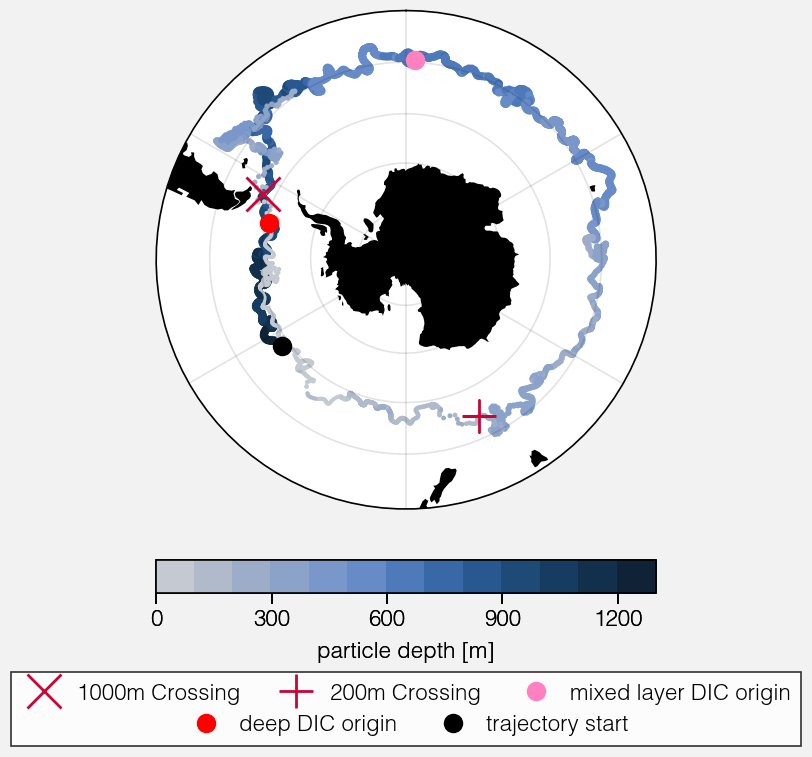

In [14]:
f, ax = plot.subplots(proj="spstere", axwidth="2.5in", axheight="3in")

lons = np.rad2deg(ds.lonParticle)
lats = np.rad2deg(ds.latParticle)

# Location of particle. Width is determined by DIC (not sDIC).
cmap = plot.Colormap("oslo_r", left=0.15, right=0.85)
p = ax.scatter(
    lons,
    lats,
    s=sizes * 2,
    c=ds.dbar,
    levels=plot.arange(0, 1300, 100),
    cmap=cmap,
)
ax.colorbar(p, loc="b", label="particle depth [m]")

# Deep (1000 m ) crossing point
(p2,) = ax.plot(
    lons[deep_crossing],
    lats[deep_crossing],
    marker="x",
    markersize=12,
    linestyle="None",
    color="cherry",
    label="1000m Crossing",
)

# Shallow (200 m) crossing point
(p3,) = ax.plot(
    lons[shallow_crossing],
    lats[shallow_crossing],
    marker="+",
    markersize=12,
    linestyle="None",
    color="cherry",
    label="200m Crossing",
)

# 200 m memory time
xorigin, yorigin, zorigin, dicorigin = figutils.mixed_layer_tracer_origin(
    np.rad2deg(ds.lonParticle),
    np.rad2deg(ds.latParticle),
    ds.zLevelParticle,
    ds.particleDIC,
)
(p4,) = ax.plot(
    xorigin,
    yorigin,
    marker="o",
    markerfacecolor="pink",
    markeredgecolor="pink",
    linestyle="None",
    label="mixed layer DIC origin",
)

# 1000 m memory time
xorigin, yorigin, zorigin, dicorigin = figutils.deep_tracer_origin(
    np.rad2deg(ds.lonParticle),
    np.rad2deg(ds.latParticle),
    ds.zLevelParticle,
    ds.particleDIC,
)
(p5,) = ax.plot(xorigin, yorigin, "or", label="deep DIC origin")

# Trajectory start
(p6,) = ax.plot(lons[0], lats[0], "ok", label="trajectory start")

ax.format(
    land=True,
    boundinglat=-40,
)

ax.legend([p2, p3, p4, p5, p6], loc="b", center=True)